# PMSM MPC dq current control

![MPC](img/mpc_structure.png)
With the help of the system model the output variables are calculated. By minimizing a cost function, the optimizer determines the optimal control variables for the following N time steps, the so-called prediction horizon. The first manipulated variable is switched on and then the system outputs are measured. When calculating the manipulated variables, the manipulated variable limits are explicitly taken into account.

![Limits](img/voltage_limits.png)
The quadratic control error area is used as the cost function. Since the control is performed in the rotating dq-coordinates, the voltage limits, which have the shape of a hexagon, are time-variant.

The optimization problem is solved iteratively using an Interior-Point Solver, which approximates the limits using barrier functions.

![Graph](img/mpc_currents_voltages.png)
The graphs show exemplary the currents and voltages for the control of a reference profile.

In [1]:
!pip install -q git+https://github.com/upb-lea/gym-electric-motor.git gekko

  ERROR: Error [WinError 2] Das System kann die angegebene Datei nicht finden while executing command git clone -q https://github.com/upb-lea/gym-electric-motor.git 'C:\Users\felix\AppData\Local\Temp\pip-req-build-keebviis'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [27]:
import numpy as np
import math
import gym_electric_motor as gem
from gekko import GEKKO
from gym_electric_motor.physical_systems import ConstantSpeedLoad

from gym_electric_motor.reference_generators import MultipleReferenceGenerator, SwitchedReferenceGenerator, \
        TriangularReferenceGenerator, WienerProcessReferenceGenerator, StepReferenceGenerator, \
        SinusoidalReferenceGenerator, ConstReferenceGenerator 
from gym_electric_motor.visualization.motor_dashboard import MotorDashboard
import matplotlib

Definition of a general controller class

In [7]:
class Controller:

    @classmethod
    def make(cls, controller_type, environment, **controller_kwargs):
        assert controller_type in _controllers.keys(), f'Controller {controller_type} unknown'
        controller = _controllers[controller_type](environment, **controller_kwargs)
        return controller

    def control(self, state, reference):
        raise NotImplementedError

    def reset(self):
        pass

Defenition of the MPC class

In [20]:
class MPC(Controller):
    def __init__(self, environment, ph=5, ref_idx_q=0, ref_idx_d=1):
        # conversion of the coordinate systems
        t32 = environment.physical_system.electrical_motor.t_32
        q = environment.physical_system.electrical_motor.q
        self._backward_transformation = (lambda quantities, eps: t32(q(quantities[::-1], eps)))
    
        # indices
        self.ref_idx_i_q = ref_idx_q
        self.ref_idx_i_d = ref_idx_d
        self.current_idx = environment.physical_system.CURRENTS_IDX
        self.voltage_idx = environment.physical_system.VOLTAGES_IDX
        self.i_sd_idx = self.current_idx[3]
        self.i_sq_idx = self.current_idx[4]
        self.u_a_idx = self.voltage_idx[0]
        self.u_b_idx = self.voltage_idx[1]
        self.u_c_idx = self.voltage_idx[2]
        self.u_sq_idx = self.voltage_idx[3]
        self.u_sd_idx = self.voltage_idx[4]
        self.omega_idx = environment.physical_system.OMEGA_IDX
        self.epsilon_idx = environment.physical_system.EPSILON_IDX

        # motor parameters
        self.tau = environment.physical_system.tau
        self.limits = environment.physical_system.limits
        self.l_q = environment.physical_system.electrical_motor.motor_parameter['l_q']
        self.l_d = environment.physical_system.electrical_motor.motor_parameter['l_d']
        self.psi_ = environment.physical_system.electrical_motor.motor_parameter['psi_p']
        self.r_s = environment.physical_system.electrical_motor.motor_parameter['r_s']
        self.p = environment.physical_system.electrical_motor.motor_parameter['p']
        self.ph_ = ph


    def control(self, state, reference):
        # initialize variables
        epsilon_el = state[self.epsilon_idx] * self.limits[self.epsilon_idx]
        omega = self.p * state[self.omega_idx] * self.limits[self.omega_idx]

        ref_q = []
        ref_d = []
        eps = []
        lim_a_up = []
        lim_a_low = []
        
        for i in range(self.ph_):
            ref_q.append(reference[self.ref_idx_i_q] * self.limits[self.i_sq_idx])
            ref_d.append(reference[self.ref_idx_i_d] * self.limits[self.i_sd_idx])
         
            eps.append(epsilon_el + (i-1) * self.tau * omega)
            lim_a_up.append(2 * self.limits[self.u_a_idx])
            lim_a_low.append(-2 * self.limits[self.u_a_idx])
        
        m = GEKKO(remote=False)
        
        # defenition of the prediction Horizon
        m.time = np.linspace(self.tau, self.tau * self.ph_, self.ph_)

        # defenition of the variables
        u_d = m.MV(value=state[self.u_sd_idx] * self.limits[self.u_sd_idx])
        u_q = m.MV(value=state[self.u_sq_idx] * self.limits[self.u_sq_idx])
        u_d.STATUS = 1
        u_q.STATUS = 1

        u_a_lim_up = m.Param(value=lim_a_up)
        u_a_lim_low = m.Param(value=lim_a_low)
        sq3 = math.sqrt(3)

        i_d = m.SV(value=state[self.i_sd_idx] * self.limits[self.i_sd_idx], lb=-self.limits[self.i_sd_idx], ub=self.limits[self.i_sd_idx] )
        i_q = m.SV(value=state[self.i_sq_idx] * self.limits[self.i_sq_idx], lb=-self.limits[self.i_sq_idx], ub=self.limits[self.i_sq_idx])

        epsilon = m.Param(value=eps)
        
        # reference trajectory
        traj_d = m.Param(value=ref_d)
        traj_q = m.Param(value=ref_q)
        
        # defenition of the constants
        omega = m.Const(value=omega)
        psi = m.Const(value=self.psi_)
        rs = m.Const(value=self.r_s)
        ld = m.Const(value=self.l_d)
        lq = m.Const(value=self.l_q)
        
        # control error
        e_d = m.CV()
        e_q = m.CV()
        e_d.STATUS = 1
        e_q.STATUS = 1
        
        # solver options
        m.options.CV_TYPE = 2
        m.options.IMODE = 6
        m.options.solver = 3
        m.options.WEB = 0
        m.options.NODES = 2
        
        # differential equations
        m.Equations([ld * i_d.dt() == u_d - rs * i_d + omega * lq * i_q,
                     lq * i_q.dt() == u_q - rs * i_q - omega * ld * i_d - omega * psi])
        
        # cost function
        m.Equations([e_d == (i_d - traj_d), e_q == (i_q - traj_q)])
        
        # voltage limitations
        m.Equation(u_a_lim_up >= 3/2 * m.cos(epsilon) * u_d - 3/2 * m.sin(epsilon) * u_q - sq3/2 * m.sin(epsilon) * u_d - sq3/2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= 3 / 2 * m.cos(epsilon) * u_d - 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_up >= sq3 * m.sin(epsilon) * u_d + sq3 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= sq3 * m.sin(epsilon) * u_d + sq3 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_up >= -3 / 2 * m.cos(epsilon) * u_d + 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        m.Equation(u_a_lim_low <= -3 / 2 * m.cos(epsilon) * u_d + 3 / 2 * m.sin(epsilon) * u_q - sq3 / 2 * m.sin(epsilon) * u_d - sq3 / 2 * m.cos(epsilon) * u_q)
        
        # object to minimize
        m.Obj(e_d)
        m.Obj(e_q)
        
        # solving optimization problem
        m.solve(disp=False)
        
        # additional voltage limitation
        u_a, u_b, u_c = self._backward_transformation((u_q.NEWVAL, u_d.NEWVAL), epsilon_el)
        u_max = max(np.absolute(u_a - u_b), np.absolute(u_b - u_c), np.absolute(u_c - u_a))
        if u_max >= 2 * self.limits[self.u_a_idx]:
            u_a = u_a / u_max * 2 * self.limits[self.u_a_idx]
            u_b = u_b / u_max * 2 * self.limits[self.u_a_idx]
            u_c = u_c / u_max * 2 * self.limits[self.u_a_idx]
        
        # Zero Point Shift
        u_0 = 0.5 * (max(u_a, u_b, u_c) + min(u_a, u_b, u_c))
        u_a -= u_0
        u_b -= u_0
        u_c -= u_0
        
        # normalization of the manipulated variables
        u_a /= self.limits[self.u_a_idx]
        u_b /= self.limits[self.u_b_idx]
        u_c /= self.limits[self.u_c_idx]
        
        return u_a, u_b, u_c

    def reset(self):
        None


_controllers = {
    'mpc': MPC
}

Defenition of the setting parameters of the motor and the limit values 

In [55]:
motor_parameter = dict(r_s=15e-3, l_d=0.37e-3, l_q=1.2e-3, psi_p=65.6e-3, p=3, j_rotor=0.06)
limit_values = dict(i=160 * 1.41, omega=12000 * np.pi / 30, u=450)
nominal_values = {key: 0.7 * limit for key, limit in limit_values.items()}

Definition of reference generators for the d- and q- components of the current

In [ ]:
q_generator = SwitchedReferenceGenerator(
        sub_generators=[
            TriangularReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 0.8), offset_range=(0, 0.8)),
            WienerProcessReferenceGenerator(reference_state='i_sq'),
            StepReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 0.8), offset_range=(0, 0.8)),
            SinusoidalReferenceGenerator(reference_state='i_sq', amplitude_range=(0, 0.8), offset_range=(0, 0.8))],
        p=[0.3, 0.2, 0.3, 0.2], super_episode_length=(100, 1000)
    )

d_generator = SwitchedReferenceGenerator(
        sub_generators=[
            TriangularReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.8), offset_range=(0, 0.8)),
            WienerProcessReferenceGenerator(reference_state='i_sd'),
            StepReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.8), offset_range=(0, 0.8)),
            SinusoidalReferenceGenerator(reference_state='i_sd', amplitude_range=(0, 0.8), offset_range=(0, 0.8)),
            ConstReferenceGenerator(reference_state='i_sd', reference_value=0)],
        p=[0.25, 0.1, 0.25, 0.2, 0.2], super_episode_length=(100, 1000)
    )

reference_generator = MultipleReferenceGenerator([q_generator, d_generator])

First, the PMSM is initialized with the previously defined motor parameters and reference generators. The MPC controller is initialized with the specified prediction horizon. Then the motor is simulated step by step. For this purpose the function for visualization is called. The manipulated variables are calculated by the MPC Controller and switched to the PMSM. This takes a long time, because the numerical effort of the MPC is large. Finally, the reward is output.

Reward = -767.6209083669602


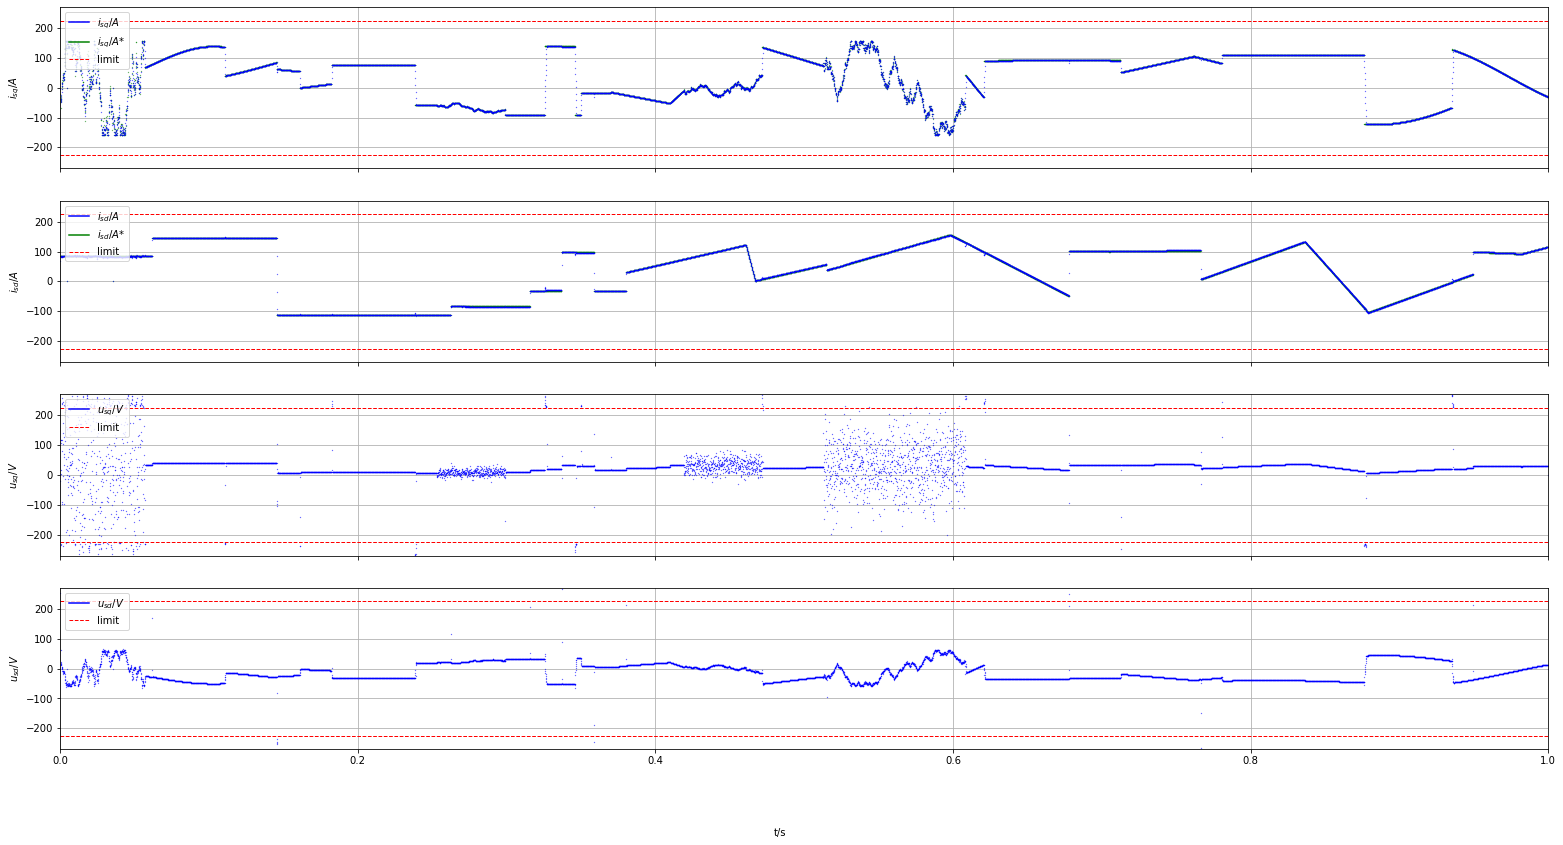

In [56]:
env = gem.make('emotor-pmsm-cont-v1',
            visualization=MotorDashboard(plots=['i_sq', 'i_sd', 'u_sq', 'u_sd'], update_cycle=1), # visualization
            load=ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30), # Fixed preset speed
            ode_solver='scipy.solve_ivp', # ODE Solver of the simulation
            reference_generator=reference_generator, # initialize the reference generators
            
            # defenitions for the reward function
            reward_function='WSE',
            reward_weights={'i_sq': 1, 'i_sd': 1},
            reward_power=0.5,
            observed_states=['i_sq', 'i_sd'],
               
            # definitions for the setting parameters
            u_sup=400,
            motor_parameter=motor_parameter,
            limit_values=limit_values,
            nominal_values=nominal_values       
    )

controller = Controller.make('mpc', env, ph=3) # initializing the MPC Controller

state, reference = env.reset()
cum_rew = 0
    
for i in range(10000): # simulate the PMSM for 10000 steps (1 second)
    env.render() # function for visualization
    action = controller.control(state, reference) # calculation of the manipulated variables
    (state, reference), reward, done, _ = env.step(action) # simulate one step of the PMSM
    cum_rew += reward # adding up the Reward 
        
print('Reward =', cum_rew)
env.close()